[Title - Edit?]
# Pop-Up Course: Better metal forming by linking experiment, modeling, and process control  
#### July 29-30, 2019

## Monte Carlo Grain Growth Simulation

[Introduction] + theory 

[Code Intro/Algo] explaination

In [2]:
# # Import required libraries

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import matplotlib.patches as patches
# # Inline Plots

%matplotlib inline

Make a 2D square lattice:

In [ ]:
# nlp=10 # number of lattice points
# N=(nlp+1)*(nlp+1)
# Q=32 #Number of states in Q-state potts model
# X=np.linspace(0,1,nlp+1)
# x,y = np.meshgrid(X,X)

Random Initial State Matrix:

In [ ]:
# state=np.random.randint(Q, size=(x.shape))
# colormatrix=np.random.rand(Q,3)

**MCS Loop Starts here:**

In [ ]:
# # Boundary detection
# isinside=np.ones(shape=(x.shape))
# for i in range(0,nlp+1):
#     for j in range(0,nlp+1):
#         if (i==0) or (j==0) or (i==nlp) or (j==nlp):
#             isinside[i][j]=0
            
        

# print(isinside)

In [ ]:
# for i in range(0,N):
#     # Pick random lattice cite
#     i=np.random.randint(len(x))
#     j=np.random.randint(len(x))
    
    

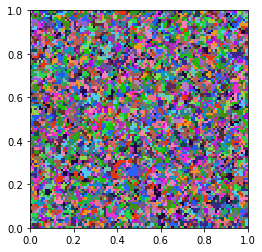

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
import time
# Function definitions


def createNeighborStateMatrix(i, j,state):
    neighborStateMatrix = np.array([[state[i - 1, j - 1], state[i - 1, j], state[i - 1, j + 1]],
                           [state[i, j - 1], state[i, j], state[i, j + 1]],
                           [state[i + 1, j - 1], state[i + 1, j], state[i + 1, j + 1]]])
    return neighborStateMatrix


def calculateKroneckerDelta(neighborStateMatrix):
    kd = np.zeros([1, 8])
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 0]):
        kd[0, 0] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 1]):
        kd[0, 1] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 2]):
        kd[0, 2] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 2]):
        kd[0, 3] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 2]):
        kd[0, 4] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 1]):
        kd[0, 5] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 0]):
        kd[0, 6] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 0]):
        kd[0, 7] = 1
    return sum(sum(kd))


def changeState(neighborStateMatrix):
    neighborI=1
    neighborJ=1
    
    while (neighborI==1) and (neighborJ==1):
        neighborI=np.random.randint(3)
        neighborJ=np.random.randint(3)
        neighborStateMatrix[1,1]=neighborStateMatrix[neighborI,neighborJ];
    return  neighborStateMatrix
nlp = 100  # number of lattice points
N = (nlp + 1) * (nlp + 1)
Q = 32  # Number of states in Q-state potts model
X = np.linspace(0, 1, nlp + 1)
x, y = np.meshgrid(X, X)

state = np.random.randint(Q, size=(x.shape))
colormatrix = np.random.rand(Q, 3)
neighborStateMatrix = np.zeros([3, 3])

# Boundary detection
isinside = np.ones(shape=(x.shape))
for i in range(0, nlp + 1):
    for j in range(0, nlp + 1):
        if (i == 0) or (j == 0) or (i == nlp) or (j == nlp):
            isinside[i][j] = 0

for mcs in range(0,100):
    for n in range(0, N):
        # Pick random lattice cite
        i = np.random.randint(1, len(x) - 1)
        j = np.random.randint(1, len(x) - 1)
        neighborStateMatrix = createNeighborStateMatrix(i, j, state)
        energyBeforeChange = 8-calculateKroneckerDelta(neighborStateMatrix)
        neighborStateMatrix=changeState(neighborStateMatrix)
        energyAfterChange = 8-calculateKroneckerDelta(neighborStateMatrix)
        dE=energyAfterChange-energyBeforeChange
        if dE<0:
            state[i,j]=neighborStateMatrix[1,1]
    # Plotting as squares
    if (mcs%10.0==0):
        fig, ax = plt.subplots(1)
        for i in range(0, nlp + 1):
           for j in range(0, nlp + 1):
               rect = patches.Rectangle((x[i, j], y[i, j]), 1.0 / nlp, 1.0 / nlp,linewidth=1, edgecolor='none', facecolor=colormatrix[state[i, j], :])
               ax.add_patch(rect)
        plt.gca().set_aspect('equal', adjustable='box')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)

